<a href="https://colab.research.google.com/github/yuxizhe/HTML-COCO-datasets-generate/blob/master/detectron2_html.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
# download, decompress the data
#!wget http://ai-sample.oss-cn-hangzhou.aliyuncs.com/image_classification/datasets/autoLayoutGroupRecognition.zip
#!cp -r /content/drive/My\ Drive/Colab\ Notebooks/detect/autoLayoutGroupRecognition.zip /content
!unzip pic.zip > /dev/null

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "pic/train.json", "pic")
#register_coco_instances("my_dataset_test", {}, "test/annotation.json", "test")
#register_coco_instances("my_dataset_val", {}, "validation/annotation.json", "validation")

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/19 14:20:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[04/19 14:20:47 d2.engine.train_loop]: Starting training from iteration 0
[04/19 14:21:02 d2.utils.events]:  eta: 0:12:56  iter: 19  total_loss: 5.350  loss_cls: 1.725  loss_box_reg: 0.776  loss_rpn_cls: 2.456  loss_rpn_loc: 0.368  time: 0.7855  data_time: 0.0127  lr: 0.000005  max_mem: 2104M
[04/19 14:21:19 d2.utils.events]:  eta: 0:12:47  iter: 39  total_loss: 4.137  loss_cls: 1.581  loss_box_reg: 0.784  loss_rpn_cls: 1.389  loss_rpn_loc: 0.401  time: 0.7960  data_time: 0.0053  lr: 0.000010  max_mem: 2123M
[04/19 14:21:35 d2.utils.events]:  eta: 0:12:32  iter: 59  total_loss: 3.090  loss_cls: 1.252  loss_box_reg: 0.801  loss_rpn_cls: 0.646  loss_rpn_loc: 0.371  time: 0.7959  data_time: 0.0047  lr: 0.000015  max_mem: 2123M
[04/19 14:21:51 d2.utils.events]:  eta: 0:12:17  iter: 79  total_loss: 2.364  loss_cls: 0.954  loss_box_reg: 0.816  loss_rpn_cls: 0.266  loss_rpn_loc: 0.327  time: 0.7978  data_time: 0.0045  lr: 0.000020  max_mem: 2123M
[04/19 14:22:07 d2.utils.events]:  eta: 0:12:0

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_train", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
train_metadata = MetadataCatalog.get("my_dataset_train")

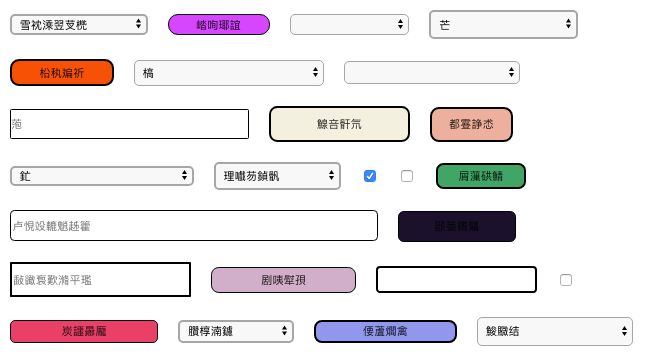

{'instances': Instances(num_instances=25, image_height=356, image_width=650, fields=[pred_boxes: Boxes(tensor([[ 11.5823, 165.2976, 193.7084, 185.3828],
        [  8.9034, 108.8110, 248.3363, 139.0714],
        [ 14.1975,  13.6389, 145.7259,  34.0655],
        [  9.7743, 210.0528, 384.3159, 240.7257],
        [  9.8094, 262.0017, 194.8270, 296.4106],
        [ 10.5658,  58.8146, 114.7527,  86.1239],
        [436.1680, 162.7476, 526.9761, 188.2641],
        [374.3540, 265.8092, 540.3161, 292.3952],
        [430.1986, 107.0991, 513.8814, 142.0192],
        [134.1404,  59.4918, 322.6613,  85.9968],
        [175.5937, 319.6254, 292.4743, 342.5278],
        [291.1082,  13.8090, 408.2961,  34.1820],
        [168.6569,  14.0145, 269.4982,  34.8710],
        [398.5883, 210.8877, 516.5762, 241.5498],
        [429.1267,   9.5100, 576.8348,  38.7597],
        [344.6618,  60.3311, 520.6600,  83.5315],
        [478.6480, 316.5453, 631.7064, 345.8132],
        [ 11.0653, 319.9831, 158.2093, 342.4520

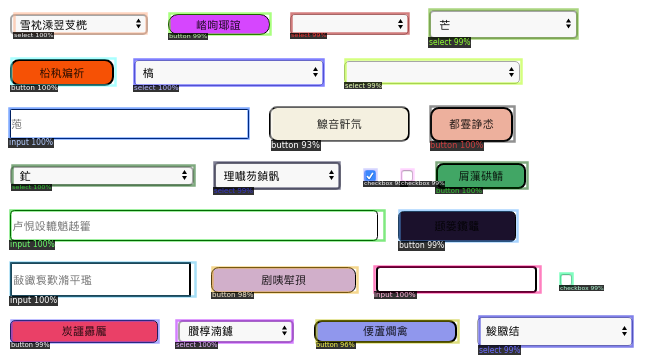

In [9]:
from detectron2.utils.visualizer import ColorMode  
im = cv2.imread("/content/pic/2020-04-19T13:37:25.052Z.png")
cv2_imshow(im)
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])